# Ensemble methods

## BalancedRandomForestClassifier

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd
from imblearn.metrics import geometric_mean_score
import shap
import numpy as np
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

In [30]:
# Cargar el dataset escalado
df = pd.read_excel("df_objetivo/df_escalado.xlsx")

# Separar X y y
X = df.drop(columns=["RIESGO_DESERCION"])
y = df["RIESGO_DESERCION"]

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       329
           1       0.82      0.82      0.82        56

    accuracy                           0.95       385
   macro avg       0.90      0.90      0.90       385
weighted avg       0.95      0.95      0.95       385

AUC: 0.9580709943551889
Matriz de confusión:
[[319  10]
 [ 10  46]]
G-mean: 0.8924


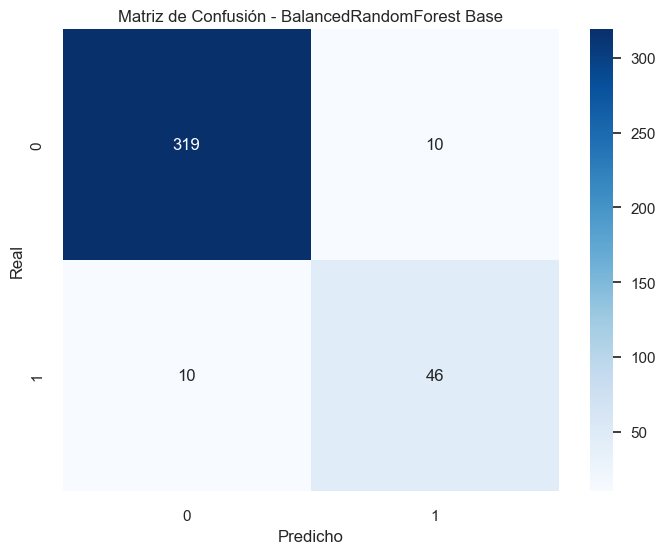

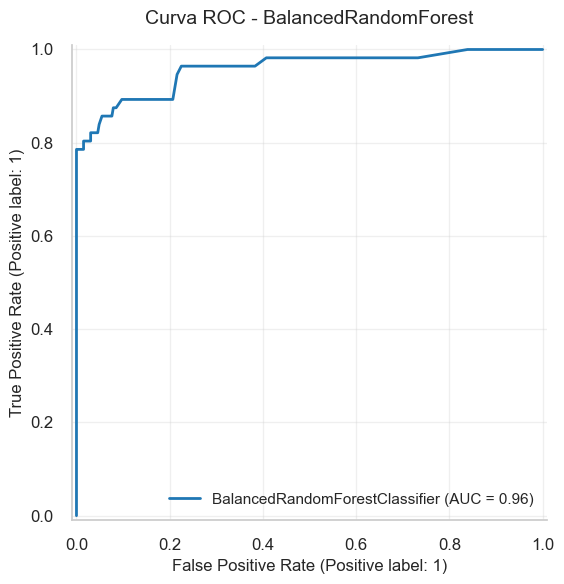

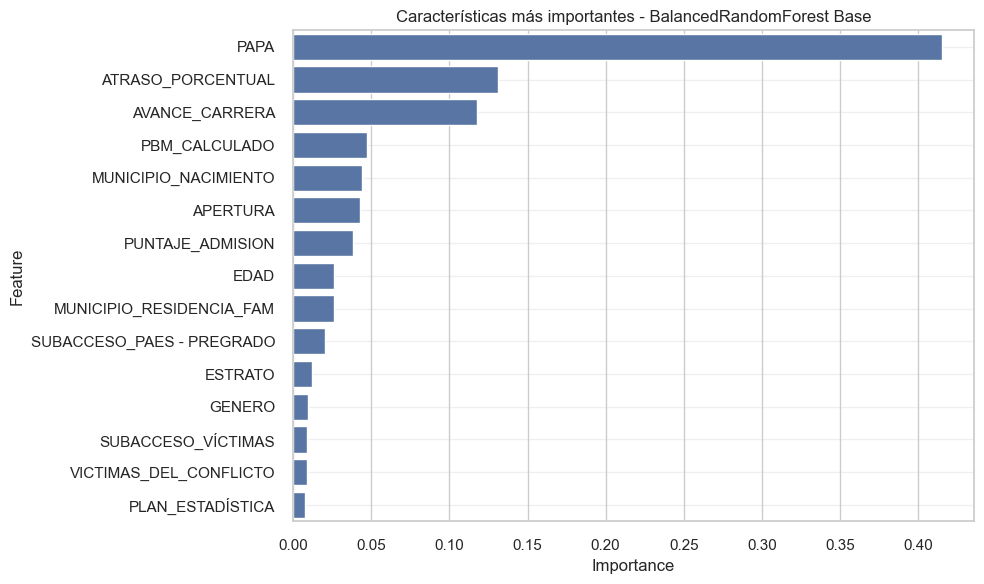

In [62]:

# Crear el modelo base (sin optimización)
brf_base = BalancedRandomForestClassifier(
    n_estimators=100,           # Número de árboles por defecto
    max_depth=None,             # Profundidad sin límite
    max_features='sqrt',        # Raíz cuadrada de las características
    min_samples_split=2,        # Valor por defecto
    min_samples_leaf=1,         # Valor por defecto
    sampling_strategy='auto',   # Balanceo automático
    replacement=False,          # Sin reemplazo por defecto
    random_state=42             # Para reproducibilidad
)

# Entrenar el modelo con los datos originales (sin balancear externamente)
brf_base.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = brf_base.predict(X_test)
y_proba = brf_base.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Evaluar el modelo
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

# Matriz de confusión
print("Matriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


g_mean = geometric_mean_score(y_test, y_pred)
print(f"G-mean: {g_mean:.4f}")

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - BalancedRandomForest Base")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Curva ROC
fig, ax = plt.subplots(figsize=(8, 6))
roc_disp = RocCurveDisplay.from_estimator(
    brf_base, X_test, y_test, ax=ax, color="#1f77b4", lw=2
)
ax.set_title("Curva ROC - BalancedRandomForest", fontsize=14, pad=15)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='both', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# Características más importantes (opcional)
importances = brf_base.feature_importances_
feature_names = X_train.columns

# Crear DataFrame con importancias
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualizar las características más importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(15))
plt.title('Características más importantes - BalancedRandomForest Base')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

### Balance RFC + GridSearch

In [24]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Crear el modelo base
brf = BalancedRandomForestClassifier(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'sampling_strategy': ['auto', 'not majority'],
    'replacement': [True, False]
}

# Configurar la validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurar y ejecutar GridSearch
grid_search = GridSearchCV(
    estimator=brf,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Obtener mejor modelo y evaluar
best_brf = grid_search.best_estimator_
y_pred = best_brf.predict(X_test)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))

# Matriz de confusión
print("Matriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Mejores hiperparámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'replacement': True, 'sampling_strategy': 'auto'}

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       329
           1       0.72      0.84      0.78        56

    accuracy                           0.93       385
   macro avg       0.85      0.89      0.87       385
weighted avg       0.94      0.93      0.93       385

AUC: 0.8922872340425533
Matriz de confusión:
[[311  18]
 [  9  47]]


In [25]:
from imblearn.metrics import geometric_mean_score
g_mean = geometric_mean_score(y_test, y_pred)
print(f"G-mean: {g_mean:.4f}")

G-mean: 0.8907
